> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Prediction and Evaluation

In [1]:
bundle_uri = 'https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/model-zoo-0.20/spacenet-vegas-buildings-ss/train/model-bundle.zip'

In [2]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2022-11-09 13:01:57:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/model-zoo-0.13/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2022-11-09 13:01:57:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/http/s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/model-zoo-0.13/spacenet-vegas-buildings-ss/train/model-bundle.zip.
2022-11-09 13:02:03:rastervision.pytorch_learner.learner: INFO - Local output dir: /opt/data/tmp/tmpyt368dek/s3/raster-vision/examples/0.13/output/spacenet-vegas-buildings-ss/train
2022-11-09 13:02:03:rastervision.pytorch_learner.learner: INFO - Remote output dir: s3://raster-vision/examples/0.13/output/spacenet-vegas-buildings-ss/train
2022-11-09 13:02:06:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpyt368dek/model-bundle/model.pth


## Get scene to predict

In [3]:
scene_id = 5631
image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

In [4]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['building', 'background'], 
    colors=['orange', 'black'])
class_config.ensure_null_class()

In [5]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

import albumentations as A

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    size=325,
    stride=325,
    transform=A.Resize(325, 325))

2022-11-09 13:02:35:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.
2022-11-09 13:02:36:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 650) is too non-square. This can slow down reading. Consider re-tiling using GDAL.


In [6]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(325, 325)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config))

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

## Visualize predictions

In [7]:
scores = pred_labels.get_score_arr(pred_labels.extent)

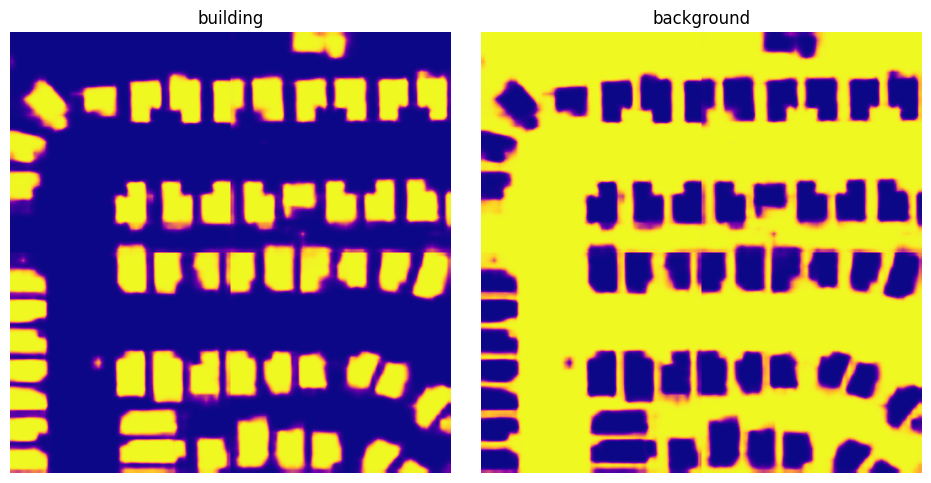

In [8]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [7]:
pred_labels.save(
    uri=f'./spacenet-vegas-buildings-ss/predict/{scene_id}',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate predictions

In [10]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

2022-10-21 10:06:26:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson.


In [11]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Evaluation for the building class:

In [12]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'building',
 'conf_mat': [[289042.0, 12212.0], [9351.0, 111895.0]],
 'conf_mat_dict': {'FN': 9351.0, 'FP': 12212.0, 'TN': 289042.0, 'TP': 111895.0},
 'conf_mat_frac': [[0.684123076923077, 0.02890414201183432],
                   [0.022132544378698226, 0.2648402366863905]],
 'conf_mat_frac_dict': {'FN': 0.022132544378698226,
                        'FP': 0.02890414201183432,
                        'TN': 0.684123076923077,
                        'TP': 0.2648402366863905},
 'count_error': 2861.0,
 'gt_count': 121246.0,
 'metrics': {'f1': 0.9121143821351279,
             'precision': 0.9016010378141442,
             'recall': 0.9228758062121637,
             'sensitivity': 0.9228758062121637,
             'specificity': 0.9594627789174583},
 'pred_count': 124107.0,
 'relative_frequency': 0.2869727810650888}

Evaluation for the background class:

In [13]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'background',
 'conf_mat': [[111895.0, 9351.0], [12212.0, 289042.0]],
 'conf_mat_dict': {'FN': 12212.0, 'FP': 9351.0, 'TN': 111895.0, 'TP': 289042.0},
 'conf_mat_frac': [[0.2648402366863905, 0.022132544378698226],
                   [0.02890414201183432, 0.684123076923077]],
 'conf_mat_frac_dict': {'FN': 0.02890414201183432,
                        'FP': 0.022132544378698226,
                        'TN': 0.2648402366863905,
                        'TP': 0.684123076923077},
 'count_error': 2861.0,
 'gt_count': 301254.0,
 'metrics': {'f1': 0.9640405105003443,
             'precision': 0.9686621334950887,
             'recall': 0.9594627789174583,
             'sensitivity': 0.9594627789174583,
             'specificity': 0.9228758062121637},
 'pred_count': 298393.0,
 'relative_frequency': 0.7130272189349113}

### Save evaluation

In [14]:
evaluation.save(f'eval-{scene_id}.json')